In [1]:
import glob
import os
import json
import datetime
import time

import torch
import pandas as pd
import numpy as np
import nibabel as nib

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

#from fastai.vision.all import *
import fastMONAI.vision_all
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from scipy import interpolate

from useful_functions import *
from utils import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available. Fastai will use the GPU.")
else:
    device = torch.device("cpu")
    print("GPU is NOT available. Fastai will use the CPU.")

GPU is NOT available. Fastai will use the CPU.


In [3]:
bids_dir = "bids"

In [4]:
session_dirs = []
for json_path in sorted(glob.glob(os.path.join(bids_dir, "sub*", "ses*", "anat", "*echo-01*mag*json"))):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
        if json_data['ProtocolName'] in ["wip_iSWI_fl3d_vibe_TRY THIS ONE"]:#, "wip_iSWI_fl3d_vibe", "wip_iSWI_fl3d_vibe_TRY THIS ONE"]:
            session_dirs.append(os.sep.join(os.path.split(json_path)[0].split(os.sep)[:-1]))
print(f"{len(session_dirs)} sessions found.")

# remove all sessions with 'sub-z0449294' in the path
session_dirs = sorted(set([s for s in session_dirs if 'sub-z0449294' not in s]))

print(f"{len(session_dirs)} sessions found.")

27 sessions found.
25 sessions found.


In [5]:
extra_files = sum((glob.glob(os.path.join(session_dir, "extra_data", "*.nii*")) for session_dir in session_dirs), [])

qsm_files2 = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*real.nii*")) for session_dir in session_dirs), []))
qsm_files = [x for x in sorted(glob.glob(os.path.join("out/qsm/*.nii"))) if 'sub-z0449294' not in x]
t2s_files = [x for x in sorted(glob.glob(os.path.join("out/t2s/*.nii"))) if 'sub-z0449294' not in x]
r2s_files = [x for x in sorted(glob.glob(os.path.join("out/r2s/*.nii"))) if 'sub-z0449294' not in x]
swi_files = [x for x in sorted(glob.glob(os.path.join("out/swi/*swi.nii"))) if 'sub-z0449294' not in x]
mag_files = [x for x in sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "magnitude_combined.nii")) for session_dir in session_dirs), [])) if 'sub-z0449294' not in x]
fmap_files = sorted([extra_file for extra_file in extra_files if 'B0.nii' in extra_file])

gre_seg_files = sorted([extra_file for extra_file in extra_files if all(pattern in extra_file for pattern in ['segmentation_clean.nii', 'tgv'])])
t1_files = sorted([extra_file for extra_file in extra_files if 'T1w_resliced' in extra_file])

# Missing CT for sub-z0449294 
ct_files = sorted([extra_file for extra_file in extra_files if 'resliced.nii' in extra_file and 'T1w' not in extra_file and 'segmentation' not in extra_file])
ct_seg_files = sorted([extra_file for extra_file in extra_files if 'resliced_segmentation.nii' in extra_file and 'T1w' not in extra_file])
ct_seg_clean_files = sorted([extra_file for extra_file in extra_files if 'resliced_segmentation_clean.nii' in extra_file and 'T1w' not in extra_file])

print(f"{len(fmap_files)} field maps found.")
print(f"{len(ct_files)} CT images found.")
print(f"{len(ct_seg_files)} raw CT segmentations found.")
print(f"{len(ct_seg_clean_files)} clean CT segmentations found.")
print(f"{len(gre_seg_files)} clean GRE segmentations found.")
print(f"{len(qsm_files)} QSM images found.")
print(f"{len(qsm_files2)} QSM (2) images found.")
print(f"{len(mag_files)} magnitude images found.")
print(f"{len(t2s_files)} T2* maps found.")
print(f"{len(r2s_files)} R2* maps found.")
print(f"{len(swi_files)} SWI maps found.")
print(f"{len(t1_files)} T1w files found.")

25 field maps found.
25 CT images found.
25 raw CT segmentations found.
25 clean CT segmentations found.
25 clean GRE segmentations found.
25 QSM images found.
25 QSM (2) images found.
25 magnitude images found.
25 T2* maps found.
25 R2* maps found.
25 SWI maps found.
25 T1w files found.


In [6]:
assert(len(qsm_files) == len(gre_seg_files))
assert(len(qsm_files) == len(t2s_files))
assert(len(qsm_files) == len(r2s_files))
assert(len(qsm_files) == len(swi_files))
assert(len(qsm_files) == len(mag_files))
assert(len(qsm_files) == len(t1_files))
assert(len(ct_files) == len(ct_seg_clean_files))

In [7]:
model_data = { 
    'CT' : { 'ct_files': ct_files, 'seg_files': ct_seg_clean_files },
    'QSM' : { 'qsm_files': qsm_files, 'seg_files': gre_seg_files },
    'QSM-SWI' : { 'qsm_files': qsm_files, 'swi_files': swi_files, 'seg_files': gre_seg_files },
    'QSM-T1-R2s' : { 'qsm_files': qsm_files, 't1_files': t1_files, 'r2s_files': r2s_files, 'seg_files': gre_seg_files },
    'QSM-T1' : { 'qsm_files': qsm_files, 't1_files': t1_files, 'seg_files': gre_seg_files },
    'T1' : { 't1_files': t1_files, 'seg_files': gre_seg_files },
    'SWI' : { 'swi_files': swi_files, 'seg_files': gre_seg_files },
    'R2s' : { 'r2s_files': r2s_files, 'seg_files': gre_seg_files },
    'GRE' : { 'mag_files': mag_files, 'seg_files': gre_seg_files },
    'QSM-FMAP': { 'qsm_files': qsm_files, 'fmap_files': fmap_files, 'seg_files': gre_seg_files },
    'FMAP': { 'fmap_files': fmap_files, 'seg_files': gre_seg_files }
}

colors = {
    'QSM' : '#a6cee3',
    'QSM-FMAP': '#1f78b4',
    'QSM-SWI' : '#b2df8a',
    'QSM-T1-R2s' : '#33a02c',
    'QSM-T1' : '#fb9a99',
    'FMAP': '#e31a1c',
    'SWI' : '#fdbf6f',
    'T1' : '#ff7f00',
    'R2s' : '#cab2d6',
    'GRE' : '#6a3d9a',
    'CT' : '#ffff99',
}

In [8]:
model_name = 'CT'
k_folds = 25
random_state = 42
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')

batch_size = 6
training_epochs = 700
lr = 0.003
ce_loss_weights = torch.Tensor([1, 1, 1])
evaluation_augmentations = [
    fastMONAI.vision_all.PadOrCrop([80, 80, 80]),
    fastMONAI.vision_all.ZNormalization(),
]

=== CT ===
infile_cols: ['ct_files']; n_input_channels: 1
Loading model: models/CT-20240322-162023-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1318033/ses-20230825/extra_data/series-3_NA_20230825101546_3_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.10499393194913864
Loading model: models/CT-20240322-162023-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1691325/ses-20240227/extra_data/series-5_16_Pelvis_16_Pelvis_20240227101660_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3620709478855133
Loading model: models/CT-20240322-162018-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0002292/ses-20240318/extra_data/series-6_16_Pelvis_16_Pelvis_20240318092750_6_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.0898023396730423
Loading model: models/CT-20240322-165315-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3268423/ses-20240109/extra_data/series-5_16_Pelvis_16_Pelvis_20240109090856_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.15072065591812134
Loading model: models/CT-20240322-165714-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1448271/ses-20231110/extra_data/series-5_16_Pelvis_16_Pelvis_20231110085011_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.07808011025190353
Loading model: models/CT-20240322-170940-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1384048/ses-20231108/extra_data/series-5_16_Pelvis_16_Pelvis_20231108092623_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.37099042534828186
Loading model: models/CT-20240322-171829-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1635498/ses-20240305/extra_data/series-5_16_Pelvis_16_Pelvis_20240305092125_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.12207125872373581
Loading model: models/CT-20240322-173639-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0163277/ses-20240123/extra_data/series-5_16_Pelvis_16_Pelvis_20240123085135_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3592894375324249
Loading model: models/CT-20240322-173915-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3220308/ses-20231009/extra_data/series-6_NA_20231009081319_6_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.08902577310800552
Loading model: models/CT-20240322-180519-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0381949/ses-20231005/extra_data/series-5_NA_20231005075647_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.07234116643667221
Loading model: models/CT-20240322-180653-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0206923/ses-20231003/extra_data/series-5_NA_20231003083739_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.06723467260599136
Loading model: models/CT-20240322-182026-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1484547/ses-20240102/extra_data/series-7_16_Pelvis_16_Pelvis_20240102093205_7_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.0771661102771759
Loading model: models/CT-20240322-184239-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1645782/ses-20231010/extra_data/series-5_NA_20231010083547_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.08638276904821396
Loading model: models/CT-20240322-185503-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0232771/ses-20240228/extra_data/series-5_16_Pelvis_16_Pelvis_20240228094427_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.06401899456977844
Loading model: models/CT-20240322-185839-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0347933/ses-20240129/extra_data/series-4_16_Pelvis_16_Pelvis_20240129121046_4_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.39239364862442017
Loading model: models/CT-20240322-191102-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3145629/ses-20231204/extra_data/series-5_16_Pelvis_16_Pelvis_20231204115121_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.06839023530483246
Loading model: models/CT-20240322-192536-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z2105112/ses-20231220/extra_data/series-5_16_Pelvis_16_Pelvis_20231220111840_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.37533360719680786
Loading model: models/CT-20240322-192946-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3212665/ses-20240305/extra_data/series-5_16_Pelvis_16_Pelvis_20240305085930_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.0521230511367321
Loading model: models/CT-20240322-195319-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z2684925/ses-20240313/extra_data/series-5_16_Pelvis_16_Pelvis_20240313093923_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.07190786302089691
Loading model: models/CT-20240322-200204-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z4043512/ses-20240112/extra_data/series-3_16_Pelvis_16_Pelvis_20240112112535_3_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.06565225124359131
Loading model: models/CT-20240322-200440-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0747844/ses-20240304/extra_data/series-5_16_Pelvis_16_Pelvis_20240304114712_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3608546555042267
Loading model: models/CT-20240322-202141-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1421134/ses-20231205/extra_data/series-3_16_Pelvis_16_Pelvis_20231205112331_3_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36809733510017395
Loading model: models/CT-20240322-202836-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1638396/ses-20240311/extra_data/series-5_16_Pelvis_16_Pelvis_20240311133704_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.09370456635951996
Loading model: models/CT-20240322-203823-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z2996397/ses-20231201/extra_data/series-5_16_Pelvis_16_Pelvis_20231201110056_5_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36261680722236633
Loading model: models/CT-20240322-204912-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0742379/ses-20240124/extra_data/series-6_16_Pelvis_16_Pelvis_20240124093902_6_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.1646345555782318
=== QSM ===
infile_cols: ['qsm_files']; n_input_channels: 1
Loading model: models/QSM-20240404-193410-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1318033_ses-20230825_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.42805054783821106
Loading model: models/QSM-20240404-194613-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1691325_ses-20240227_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4440873861312866
Loading model: models/QSM-20240404-200251-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0002292_ses-20240318_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.24963511526584625
Loading model: models/QSM-20240404-200938-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3268423_ses-20240109_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.2598250210285187
Loading model: models/QSM-20240404-203013-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1448271_ses-20231110_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.49917352199554443
Loading model: models/QSM-20240404-205511-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1384048_ses-20231108_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3669090270996094
Loading model: models/QSM-20240404-210427-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1635498_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38169366121292114
Loading model: models/QSM-20240404-210934-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0163277_ses-20240123_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38959240913391113
Loading model: models/QSM-20240404-212652-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z3220308_ses-20231009_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.42578285932540894
Loading model: models/QSM-20240404-213045-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0381949_ses-20231005_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4157220125198364
Loading model: models/QSM-20240404-213957-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0206923_ses-20231003_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.393423855304718
Loading model: models/QSM-20240404-215412-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.44913601875305176
Loading model: models/QSM-20240404-220858-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1645782_ses-20231010_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.397781103849411
Loading model: models/QSM-20240404-222050-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0232771_ses-20240228_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3980151116847992
Loading model: models/QSM-20240404-222514-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0347933_ses-20240129_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.5474079847335815
Loading model: models/QSM-20240404-223854-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3145629_ses-20231204_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4346502423286438
Loading model: models/QSM-20240404-230110-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z2105112_ses-20231220_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38124164938926697
Loading model: models/QSM-20240404-230748-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3212665_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.24552559852600098
Loading model: models/QSM-20240404-232826-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z2684925_ses-20240313_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4199175238609314
Loading model: models/QSM-20240404-232052-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z4043512_ses-20240112_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.23457711935043335
Loading model: models/QSM-20240404-234457-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0747844_ses-20240304_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4373343884944916
Loading model: models/QSM-20240405-000418-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1421134_ses-20231205_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.44561299681663513
Loading model: models/QSM-20240405-001415-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1638396_ses-20240311_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4424882233142853
Loading model: models/QSM-20240405-002415-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z2996397_ses-20231201_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38106784224510193
Loading model: models/QSM-20240405-004158-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0742379_ses-20240124_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.5237584114074707
=== QSM-SWI ===
infile_cols: ['qsm_files', 'swi_files']; n_input_channels: 2
Loading model: models/QSM-SWI-20240406-093356-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1318033_ses-20230825_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.35938647389411926
Loading model: models/QSM-SWI-20240406-095930-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1691325_ses-20240227_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.44753071665763855
Loading model: models/QSM-SWI-20240406-100728-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0002292_ses-20240318_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.33353155851364136
Loading model: models/QSM-SWI-20240406-102932-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3268423_ses-20240109_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.2659398913383484
Loading model: models/QSM-SWI-20240406-103401-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1448271_ses-20231110_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.5098202228546143
Loading model: models/QSM-SWI-20240406-105425-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1384048_ses-20231108_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36221951246261597
Loading model: models/QSM-SWI-20240406-110158-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1635498_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3810124397277832
Loading model: models/QSM-SWI-20240406-111532-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0163277_ses-20240123_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.392226904630661
Loading model: models/QSM-SWI-20240406-113254-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z3220308_ses-20231009_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4149318337440491
Loading model: models/QSM-SWI-20240406-113404-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0381949_ses-20231005_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.43519827723503113
Loading model: models/QSM-SWI-20240406-114726-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0206923_ses-20231003_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.39042553305625916
Loading model: models/QSM-SWI-20240406-122406-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.44047123193740845
Loading model: models/QSM-SWI-20240406-122504-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1645782_ses-20231010_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.37541401386260986
Loading model: models/QSM-SWI-20240406-123810-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0232771_ses-20240228_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.41650596261024475
Loading model: models/QSM-SWI-20240406-125823-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0347933_ses-20240129_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.39423438906669617
Loading model: models/QSM-SWI-20240406-131143-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3145629_ses-20231204_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.46372291445732117
Loading model: models/QSM-SWI-20240406-132153-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z2105112_ses-20231220_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3880996108055115
Loading model: models/QSM-SWI-20240406-133942-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3212665_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.23218856751918793
Loading model: models/QSM-SWI-20240406-134917-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z2684925_ses-20240313_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3261967599391937
Loading model: models/QSM-SWI-20240406-140840-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z4043512_ses-20240112_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.22890253365039825
Loading model: models/QSM-SWI-20240406-144138-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0747844_ses-20240304_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4469115138053894
Loading model: models/QSM-SWI-20240406-144648-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1421134_ses-20231205_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.42674338817596436
Loading model: models/QSM-SWI-20240406-151524-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1638396_ses-20240311_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4279640018939972
Loading model: models/QSM-SWI-20240406-151914-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z2996397_ses-20231201_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3841499090194702
Loading model: models/QSM-SWI-20240406-151946-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0742379_ses-20240124_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.4942237138748169
=== QSM-T1-R2s ===
infile_cols: ['qsm_files', 't1_files', 'r2s_files']; n_input_channels: 3
Loading model: models/QSM-T1-R2s-20240405-200745-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1318033_ses-20230825_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4158538579940796
Loading model: models/QSM-T1-R2s-20240405-203754-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1691325_ses-20240227_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4170067012310028
Loading model: models/QSM-T1-R2s-20240405-204000-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0002292_ses-20240318_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3118132948875427
Loading model: models/QSM-T1-R2s-20240405-204920-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3268423_ses-20240109_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3784339129924774
Loading model: models/QSM-T1-R2s-20240405-212344-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1448271_ses-20231110_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.4509694576263428
Loading model: models/QSM-T1-R2s-20240405-212905-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1384048_ses-20231108_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.362895667552948
Loading model: models/QSM-T1-R2s-20240405-213415-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1635498_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3783106505870819
Loading model: models/QSM-T1-R2s-20240405-221145-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0163277_ses-20240123_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3975670635700226
Loading model: models/QSM-T1-R2s-20240405-223423-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z3220308_ses-20231009_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.42195966839790344
Loading model: models/QSM-T1-R2s-20240405-223429-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0381949_ses-20231005_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.30159997940063477
Loading model: models/QSM-T1-R2s-20240405-230532-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0206923_ses-20231003_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38418859243392944
Loading model: models/QSM-T1-R2s-20240405-230817-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4285174310207367
Loading model: models/QSM-T1-R2s-20240405-234202-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1645782_ses-20231010_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 1.0
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 0
Loss: 0.36559268832206726
Loading model: models/QSM-T1-R2s-20240405-234653-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0232771_ses-20240228_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.43756625056266785
Loading model: models/QSM-T1-R2s-20240405-235155-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0347933_ses-20240129_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.39690110087394714
Loading model: models/QSM-T1-R2s-20240406-002523-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3145629_ses-20231204_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.40018463134765625
Loading model: models/QSM-T1-R2s-20240406-002903-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z2105112_ses-20231220_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38567981123924255
Loading model: models/QSM-T1-R2s-20240406-005627-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3212665_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3423725962638855
Loading model: models/QSM-T1-R2s-20240406-011451-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z2684925_ses-20240313_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.29428523778915405
Loading model: models/QSM-T1-R2s-20240406-012254-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z4043512_ses-20240112_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.2992599308490753
Loading model: models/QSM-T1-R2s-20240406-020730-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0747844_ses-20240304_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.431304931640625
Loading model: models/QSM-T1-R2s-20240406-021336-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1421134_ses-20231205_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4196508526802063
Loading model: models/QSM-T1-R2s-20240406-024527-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1638396_ses-20240311_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.43274471163749695
Loading model: models/QSM-T1-R2s-20240406-030111-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z2996397_ses-20231201_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4005579650402069
Loading model: models/QSM-T1-R2s-20240406-030947-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0742379_ses-20240124_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.45163825154304504
=== QSM-T1 ===
infile_cols: ['qsm_files', 't1_files']; n_input_channels: 2
Loading model: models/QSM-T1-20240406-033809-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1318033_ses-20230825_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.367511123418808
Loading model: models/QSM-T1-20240406-034536-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1691325_ses-20240227_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4498734176158905
Loading model: models/QSM-T1-20240406-035411-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0002292_ses-20240318_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.27539578080177307
Loading model: models/QSM-T1-20240406-042853-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3268423_ses-20240109_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.2727191150188446
Loading model: models/QSM-T1-20240406-043913-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1448271_ses-20231110_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.4334370493888855
Loading model: models/QSM-T1-20240406-044559-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1384048_ses-20231108_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.379159539937973
Loading model: models/QSM-T1-20240406-051159-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1635498_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4036404490470886
Loading model: models/QSM-T1-20240406-051834-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0163277_ses-20240123_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3708525598049164
Loading model: models/QSM-T1-20240406-053243-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z3220308_ses-20231009_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4033593535423279
Loading model: models/QSM-T1-20240406-055223-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0381949_ses-20231005_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38665473461151123
Loading model: models/QSM-T1-20240406-055656-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0206923_ses-20231003_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3946381211280823
Loading model: models/QSM-T1-20240406-061317-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.43898653984069824
Loading model: models/QSM-T1-20240406-063223-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1645782_ses-20231010_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38550275564193726
Loading model: models/QSM-T1-20240406-065135-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0232771_ses-20240228_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.41967466473579407
Loading model: models/QSM-T1-20240406-065409-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0347933_ses-20240129_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.45859384536743164
Loading model: models/QSM-T1-20240406-072522-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3145629_ses-20231204_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.40709173679351807
Loading model: models/QSM-T1-20240406-073048-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z2105112_ses-20231220_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3789239823818207
Loading model: models/QSM-T1-20240406-073346-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3212665_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3281424343585968
Loading model: models/QSM-T1-20240406-080913-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z2684925_ses-20240313_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36686286330223083
Loading model: models/QSM-T1-20240406-081928-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z4043512_ses-20240112_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3175925016403198
Loading model: models/QSM-T1-20240406-082403-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0747844_ses-20240304_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.43334850668907166
Loading model: models/QSM-T1-20240406-085215-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1421134_ses-20231205_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4306867718696594
Loading model: models/QSM-T1-20240406-085727-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1638396_ses-20240311_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4110361635684967
Loading model: models/QSM-T1-20240406-092357-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z2996397_ses-20231201_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.39801815152168274
Loading model: models/QSM-T1-20240406-092531-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0742379_ses-20240124_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.48703181743621826
=== T1 ===
infile_cols: ['t1_files']; n_input_channels: 1
Loading model: models/T1-20240405-055604-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1318033/ses-20230825/extra_data/sub-z1318033_ses-20230825_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4547812342643738
Loading model: models/T1-20240405-061633-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1691325/ses-20240227/extra_data/sub-z1691325_ses-20240227_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4053158462047577
Loading model: models/T1-20240405-061705-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0002292/ses-20240318/extra_data/sub-z0002292_ses-20240318_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4364168643951416
Loading model: models/T1-20240405-062011-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3268423/ses-20240109/extra_data/sub-z3268423_ses-20240109_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3907875120639801
Loading model: models/T1-20240405-063921-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1448271/ses-20231110/extra_data/sub-z1448271_ses-20231110_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.43378233909606934
Loading model: models/T1-20240405-065147-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1384048/ses-20231108/extra_data/sub-z1384048_ses-20231108_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4076284170150757
Loading model: models/T1-20240405-070744-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1635498/ses-20240305/extra_data/sub-z1635498_ses-20240305_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4597577452659607
Loading model: models/T1-20240405-071429-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0163277/ses-20240123/extra_data/sub-z0163277_ses-20240123_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4778331220149994
Loading model: models/T1-20240405-072608-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z3220308/ses-20231009/extra_data/sub-z3220308_ses-20231009_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4057258665561676
Loading model: models/T1-20240405-073307-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0381949/ses-20231005/extra_data/sub-z0381949_ses-20231005_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.46123769879341125
Loading model: models/T1-20240405-074007-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0206923/ses-20231003/extra_data/sub-z0206923_ses-20231003_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4145531952381134
Loading model: models/T1-20240405-075744-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1484547/ses-20240102/extra_data/sub-z1484547_ses-20240102_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.42198407649993896
Loading model: models/T1-20240405-080429-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1645782/ses-20231010/extra_data/sub-z1645782_ses-20231010_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38236162066459656
Loading model: models/T1-20240405-080940-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0232771/ses-20240228/extra_data/sub-z0232771_ses-20240228_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.46583741903305054
Loading model: models/T1-20240405-083321-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0347933/ses-20240129/extra_data/sub-z0347933_ses-20240129_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.5156345963478088
Loading model: models/T1-20240405-083900-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3145629/ses-20231204/extra_data/sub-z3145629_ses-20231204_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.41157978773117065
Loading model: models/T1-20240405-083930-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z2105112/ses-20231220/extra_data/sub-z2105112_ses-20231220_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3965100347995758
Loading model: models/T1-20240405-085521-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3212665/ses-20240305/extra_data/sub-z3212665_ses-20240305_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4583573043346405
Loading model: models/T1-20240405-090535-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z2684925/ses-20240313/extra_data/sub-z2684925_ses-20240313_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.34906667470932007
Loading model: models/T1-20240405-091245-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z4043512/ses-20240112/extra_data/sub-z4043512_ses-20240112_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.5041822791099548
Loading model: models/T1-20240405-093628-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0747844/ses-20240304/extra_data/sub-z0747844_ses-20240304_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 0.3333333333333333
True markers: 1
False positive markers: 0 (0 were known calcification)
False negative markers: 2
Loss: 0.5328037738800049
Loading model: models/T1-20240405-093701-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1421134/ses-20231205/extra_data/sub-z1421134_ses-20231205_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4671066999435425
Loading model: models/T1-20240405-095843-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1638396/ses-20240311/extra_data/sub-z1638396_ses-20240311_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.43209755420684814
Loading model: models/T1-20240405-095914-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z2996397/ses-20231201/extra_data/sub-z2996397_ses-20231201_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.40890830755233765
Loading model: models/T1-20240405-100332-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0742379/ses-20240124/extra_data/sub-z0742379_ses-20240124_acq-t1tragradientseed_run-01_T1w_resliced.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.48075664043426514
=== SWI ===
infile_cols: ['swi_files']; n_input_channels: 1
Loading model: models/SWI-20240405-004402-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z1318033_ses-20230825_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.30211636424064636
Loading model: models/SWI-20240405-005911-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z1691325_ses-20240227_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4147738814353943
Loading model: models/SWI-20240405-011700-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z0002292_ses-20240318_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3671419024467468
Loading model: models/SWI-20240405-012409-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z3268423_ses-20240109_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3266045153141022
Loading model: models/SWI-20240405-013437-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z1448271_ses-20231110_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.4807448387145996
Loading model: models/SWI-20240405-020338-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z1384048_ses-20231108_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3779834508895874
Loading model: models/SWI-20240405-020509-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z1635498_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.37742990255355835
Loading model: models/SWI-20240405-020941-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z0163277_ses-20240123_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.40476903319358826
Loading model: models/SWI-20240405-024031-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z3220308_ses-20231009_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4131859242916107
Loading model: models/SWI-20240405-024057-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z0381949_ses-20231005_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.5103296637535095
Loading model: models/SWI-20240405-024800-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z0206923_ses-20231003_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.39878132939338684
Loading model: models/SWI-20240405-031138-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3094261884689331
Loading model: models/SWI-20240405-031341-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z1645782_ses-20231010_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3764442503452301
Loading model: models/SWI-20240405-032309-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z0232771_ses-20240228_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4444598853588104
Loading model: models/SWI-20240405-035103-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z0347933_ses-20240129_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3809022307395935
Loading model: models/SWI-20240405-035238-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z3145629_ses-20231204_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.5602312088012695
Loading model: models/SWI-20240405-035440-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z2105112_ses-20231220_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3855067491531372
Loading model: models/SWI-20240405-041707-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z3212665_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.44175493717193604
Loading model: models/SWI-20240405-042355-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z2684925_ses-20240313_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36036816239356995
Loading model: models/SWI-20240405-044317-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z4043512_ses-20240112_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.30786940455436707
Loading model: models/SWI-20240405-044418-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z0747844_ses-20240304_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4922676384449005
Loading model: models/SWI-20240405-050657-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z1421134_ses-20231205_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4318453371524811
Loading model: models/SWI-20240405-053107-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z1638396_ses-20240311_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.41847461462020874
Loading model: models/SWI-20240405-053315-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/swi/sub-z2996397_ses-20231201_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3829539120197296
Loading model: models/SWI-20240405-053753-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/swi/sub-z0742379_ses-20240124_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.5511376261711121
=== R2s ===
infile_cols: ['r2s_files']; n_input_channels: 1
Loading model: models/R2s-20240405-102401-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z1318033_ses-20230825_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.44013628363609314
Loading model: models/R2s-20240405-102609-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z1691325_ses-20240227_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3887336850166321
Loading model: models/R2s-20240405-102741-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z0002292_ses-20240318_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4149264693260193
Loading model: models/R2s-20240405-104734-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z3268423_ses-20240109_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.37861454486846924
Loading model: models/R2s-20240405-105809-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z1448271_ses-20231110_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4167895019054413
Loading model: models/R2s-20240405-110247-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z1384048_ses-20231108_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36538806557655334
Loading model: models/R2s-20240405-111110-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z1635498_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.37915554642677307
Loading model: models/R2s-20240405-113841-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z0163277_ses-20240123_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4898924231529236
Loading model: models/R2s-20240405-114509-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z3220308_ses-20231009_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4163009524345398
Loading model: models/R2s-20240405-115449-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z0381949_ses-20231005_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.352629691362381
Loading model: models/R2s-20240405-121019-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z0206923_ses-20231003_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.43610846996307373
Loading model: models/R2s-20240405-121503-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4079236686229706
Loading model: models/R2s-20240405-124319-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z1645782_ses-20231010_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38091886043548584
Loading model: models/R2s-20240405-125109-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z0232771_ses-20240228_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4340665638446808
Loading model: models/R2s-20240405-125214-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z0347933_ses-20240129_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3742212951183319
Loading model: models/R2s-20240405-131653-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z3145629_ses-20231204_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4517214298248291
Loading model: models/R2s-20240405-132217-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z2105112_ses-20231220_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3883199989795685
Loading model: models/R2s-20240405-132850-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z3212665_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4476622939109802
Loading model: models/R2s-20240405-135200-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z2684925_ses-20240313_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.40978461503982544
Loading model: models/R2s-20240405-135225-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z4043512_ses-20240112_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4617004096508026
Loading model: models/R2s-20240405-141523-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z0747844_ses-20240304_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4801279306411743
Loading model: models/R2s-20240405-141839-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z1421134_ses-20231205_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.46518951654434204
Loading model: models/R2s-20240405-142751-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z1638396_ses-20240311_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.427079975605011
Loading model: models/R2s-20240405-144336-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/r2s/sub-z2996397_ses-20231201_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.41868844628334045
Loading model: models/R2s-20240405-144612-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/r2s/sub-z0742379_ses-20240124_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.43238741159439087
=== GRE ===
infile_cols: ['mag_files']; n_input_channels: 1
Loading model: models/GRE-20240405-150239-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1318033/ses-20230825/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3169919550418854
Loading model: models/GRE-20240405-152126-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1691325/ses-20240227/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.387630820274353
Loading model: models/GRE-20240405-152603-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0002292/ses-20240318/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.23448430001735687
Loading model: models/GRE-20240405-155600-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3268423/ses-20240109/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3719351291656494
Loading model: models/GRE-20240405-160131-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1448271/ses-20231110/extra_data/magnitude_combined.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.47698476910591125
Loading model: models/GRE-20240405-161318-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1384048/ses-20231108/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3711797893047333
Loading model: models/GRE-20240405-162042-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1635498/ses-20240305/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.378140926361084
Loading model: models/GRE-20240405-162519-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0163277/ses-20240123/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4118210971355438
Loading model: models/GRE-20240405-165158-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z3220308/ses-20231009/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4284638464450836
Loading model: models/GRE-20240405-165717-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0381949/ses-20231005/extra_data/magnitude_combined.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.4248062074184418
Loading model: models/GRE-20240405-170438-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0206923/ses-20231003/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4029568135738373
Loading model: models/GRE-20240405-172234-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1484547/ses-20240102/extra_data/magnitude_combined.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.42976656556129456
Loading model: models/GRE-20240405-172453-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1645782/ses-20231010/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.362017959356308
Loading model: models/GRE-20240405-174413-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0232771/ses-20240228/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.40285924077033997
Loading model: models/GRE-20240405-175552-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0347933/ses-20240129/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.37458112835884094
Loading model: models/GRE-20240405-180616-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3145629/ses-20231204/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4215394854545593
Loading model: models/GRE-20240405-182831-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z2105112/ses-20231220/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.38069671392440796
Loading model: models/GRE-20240405-183038-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3212665/ses-20240305/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36756882071495056
Loading model: models/GRE-20240405-184637-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z2684925/ses-20240313/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.39259102940559387
Loading model: models/GRE-20240405-190121-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z4043512/ses-20240112/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.2421264797449112
Loading model: models/GRE-20240405-190841-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0747844/ses-20240304/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4473836123943329
Loading model: models/GRE-20240405-192929-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1421134/ses-20231205/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.42178627848625183
Loading model: models/GRE-20240405-193715-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1638396/ses-20240311/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4048817455768585
Loading model: models/GRE-20240405-195503-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z2996397/ses-20231201/extra_data/magnitude_combined.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36602088809013367
Loading model: models/GRE-20240405-200013-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0742379/ses-20240124/extra_data/magnitude_combined.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.4536900222301483
=== QSM-FMAP ===
infile_cols: ['qsm_files', 'fmap_files']; n_input_channels: 2
Loading model: models/QSM-FMAP-20240404-132733-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1318033_ses-20230825_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.0
Marker Recall: 0.0
True markers: 0
False positive markers: 1 (0 were known calcification)
False negative markers: 3
Loss: 0.6727012395858765
Loading model: models/QSM-FMAP-20240404-131545-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1691325_ses-20240227_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.3333333333333333
Marker Recall: 1.3333333333333333
True markers: 4
False positive markers: -1 (0 were known calcification)
False negative markers: -1
Loss: 1.4710769653320312
Loading model: models/QSM-FMAP-20240404-131545-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0002292_ses-20240318_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 1.9421215057373047
Loading model: models/QSM-FMAP-20240404-135657-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3268423_ses-20240109_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.2698216140270233
Loading model: models/QSM-FMAP-20240404-140913-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1448271_ses-20231110_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.4993855953216553
Loading model: models/QSM-FMAP-20240404-141231-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1384048_ses-20231108_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3603056073188782
Loading model: models/QSM-FMAP-20240404-144833-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1635498_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3651813566684723
Loading model: models/QSM-FMAP-20240404-145831-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0163277_ses-20240123_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3729521930217743
Loading model: models/QSM-FMAP-20240404-150532-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z3220308_ses-20231009_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.4242486357688904
Loading model: models/QSM-FMAP-20240404-152928-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0381949_ses-20231005_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (1 were known calcification)
False negative markers: 1
Loss: 0.5759174227714539
Loading model: models/QSM-FMAP-20240404-153739-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0206923_ses-20231003_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3653393089771271
Loading model: models/QSM-FMAP-20240404-155322-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.41541895270347595
Loading model: models/QSM-FMAP-20240404-160448-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1645782_ses-20231010_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 1.0
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 0
Loss: 0.3583471179008484
Loading model: models/QSM-FMAP-20240404-162708-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0232771_ses-20240228_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3952687978744507
Loading model: models/QSM-FMAP-20240404-163411-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0347933_ses-20240129_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3774184584617615
Loading model: models/QSM-FMAP-20240404-164430-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3145629_ses-20231204_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.41867122054100037
Loading model: models/QSM-FMAP-20240404-171524-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z2105112_ses-20231220_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.373516708612442
Loading model: models/QSM-FMAP-20240404-171720-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z3212665_ses-20240305_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.16797329485416412
Loading model: models/QSM-FMAP-20240404-172147-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z2684925_ses-20240313_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.31129586696624756
Loading model: models/QSM-FMAP-20240404-174804-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z4043512_ses-20240112_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.26431286334991455
Loading model: models/QSM-FMAP-20240404-181624-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z0747844_ses-20240304_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.42608916759490967
Loading model: models/QSM-FMAP-20240404-182941-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1421134_ses-20231205_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.42209747433662415
Loading model: models/QSM-FMAP-20240404-183736-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z1638396_ses-20240311_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3714548945426941
Loading model: models/QSM-FMAP-20240404-190924-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: out/qsm/sub-z2996397_ses-20231201_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3573201596736908
Loading model: models/QSM-FMAP-20240404-191023-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: out/qsm/sub-z0742379_ses-20240124_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.46423643827438354
=== FMAP ===
infile_cols: ['fmap_files']; n_input_channels: 1
Loading model: models/FMAP-20240408-094032-0-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1318033/ses-20230825/extra_data/B0.nii
Marker Precision: 0.0
Marker Recall: 0.0
True markers: 0
False positive markers: 1 (0 were known calcification)
False negative markers: 3
Loss: 0.6712831854820251
Loading model: models/FMAP-20240408-094032-1-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1691325/ses-20240227/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3788819909095764
Loading model: models/FMAP-20240408-094032-2-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0002292/ses-20240318/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3702618181705475
Loading model: models/FMAP-20240408-095850-3-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3268423/ses-20240109/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.35896527767181396
Loading model: models/FMAP-20240408-101622-4-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1448271/ses-20231110/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.46587052941322327
Loading model: models/FMAP-20240408-101923-5-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1384048/ses-20231108/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3798777163028717
Loading model: models/FMAP-20240408-102523-6-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1635498/ses-20240305/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3707045018672943
Loading model: models/FMAP-20240408-105052-7-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0163277/ses-20240123/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.362581342458725
Loading model: models/FMAP-20240408-105147-8-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z3220308/ses-20231009/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.41714638471603394
Loading model: models/FMAP-20240408-105544-9-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0381949/ses-20231005/extra_data/B0.nii
Marker Precision: 0.0
Marker Recall: 0.0
True markers: 0
False positive markers: 1 (0 were known calcification)
False negative markers: 3
Loss: 0.6688713431358337
Loading model: models/FMAP-20240408-111631-10-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0206923/ses-20231003/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3754417598247528
Loading model: models/FMAP-20240408-112540-11-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z1484547/ses-20240102/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.39057403802871704
Loading model: models/FMAP-20240408-114226-12-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1645782/ses-20231010/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36489081382751465
Loading model: models/FMAP-20240408-120654-13-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0232771/ses-20240228/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4209740459918976
Loading model: models/FMAP-20240408-115620-14-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0347933/ses-20240129/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36348286271095276
Loading model: models/FMAP-20240408-121459-15-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3145629/ses-20231204/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.42710888385772705
Loading model: models/FMAP-20240408-121948-16-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z2105112/ses-20231220/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.36734551191329956
Loading model: models/FMAP-20240408-123955-17-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z3212665/ses-20240305/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.2057500034570694
Loading model: models/FMAP-20240408-124149-18-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z2684925/ses-20240313/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3429981470108032
Loading model: models/FMAP-20240408-124809-19-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z4043512/ses-20240112/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.31652921438217163
Loading model: models/FMAP-20240408-132853-20-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z0747844/ses-20240304/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.425470769405365
Loading model: models/FMAP-20240408-132909-21-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1421134/ses-20231205/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 0 (0 were known calcification)
False negative markers: 1
Loss: 0.4580019414424896
Loading model: models/FMAP-20240408-133754-22-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z1638396/ses-20240311/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3678613603115082
Loading model: models/FMAP-20240408-135713-23-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Input file: bids/sub-z2996397/ses-20231201/extra_data/B0.nii
Marker Precision: 1.0
Marker Recall: 1.0
True markers: 3
False positive markers: 0 (0 were known calcification)
False negative markers: 0
Loss: 0.3701167404651642
Loading model: models/FMAP-20240408-140824-24-best.pth


Saved filed doesn't contain an optimizer state.


0/1; 

Input file: bids/sub-z0742379/ses-20240124/extra_data/B0.nii
Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
True markers: 2
False positive markers: 1 (0 were known calcification)
False negative markers: 1
Loss: 0.443633109331131


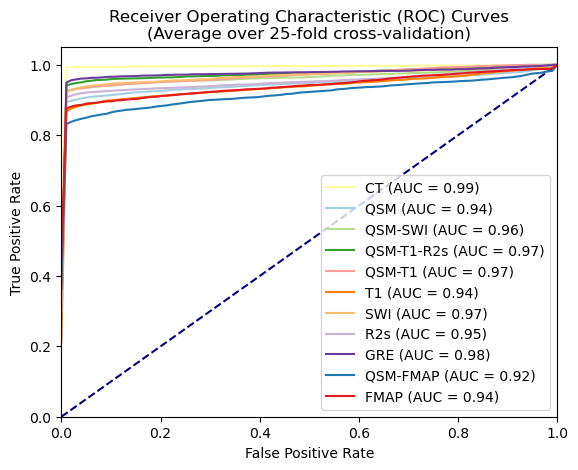

In [9]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
model_marker_precisions = {}
model_marker_recalls = {}
model_tps = {}
model_fps = {}
model_fps_markers_as_calcs = {}
model_fns = {}
model_in_files = {}
losses = {}

for model in model_data.keys():#['CT']:
    print(f"=== {model} ===")

    df = pd.DataFrame(model_data[model])
    infile_cols = [key for key in list(model_data[model].keys()) if key != 'seg_files']
    n_input_channels = len(infile_cols)
    print(f"infile_cols: {infile_cols}; n_input_channels: {n_input_channels}")

    # determine resampling suggestion
    if model == 'CT':
        med_dataset = fastMONAI.vision_all.MedDataset(
            img_list=df.seg_files.tolist(),
            dtype=fastMONAI.vision_all.MedMask
        )
        suggested_voxelsize, requires_resampling = med_dataset.suggestion()
        largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)

    # k validation folds
    kf = KFold(n_splits=k_folds, random_state=random_state, shuffle=True)

    marker_precisions = []
    marker_recalls = []
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    tps = []
    fps = []
    fps_markers_as_calcs = []
    fns = []
    fm_losses = []
    calc_losses = []
    in_files = []


    for i, (train_index, valid_index) in enumerate(kf.split(df)):

        dblock = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter(valid_index),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )

        dls = fastMONAI.vision_all.DataLoaders.from_dblock(dblock, df, bs=batch_size)

        learn = fastMONAI.vision_all.Learner(
            dls,
            model=UNet(
                spatial_dims=3,
                in_channels=n_input_channels,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2
            ),
            loss_func=DiceCELoss(
                to_onehot_y=True,
                include_background=True,
                softmax=True,
                ce_weight=ce_loss_weights
            ),
            opt_func=fastMONAI.vision_all.ranger,
            metrics=[fastMONAI.vision_all.multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]#.to_fp16()
        )

        model_file = glob.glob(f"models/{model}-2024*-*-{i}-best*")[0]
        print(f"Loading model: {model_file}")
        learn = learn.load(model_file.replace("models/", "").replace(".pth", ""))

        if torch.cuda.is_available():
            learn.model.cuda()

        # Compute metrics on the entire dataset
        correct_markers = MarkersIdentified()

        dblock_valid_eval = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter([]),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize,
        )
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=1, sampler=fastMONAI.vision_all.SequentialSampler)
        for i, (x, y) in enumerate(dls_valid_eval.train):
            print(f"{i}/{len(dls_valid_eval.train)}", end="; ")
            pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
            correct_markers.accumulate(pred=pred.cpu(), targ=y.cpu())

        marker_tps = correct_markers.overlap_count
        marker_fps = correct_markers.pred_marker_count - correct_markers.overlap_count
        marker_fns = correct_markers.targ_marker_count - correct_markers.overlap_count

        tps.append(marker_tps)
        fps.append(marker_fps)
        fps_markers_as_calcs.append(correct_markers.calcification_misclassifications)
        fns.append(marker_fns)

        marker_precision = (marker_tps / (marker_tps + marker_fps)) if (marker_tps + marker_fps) > 0 else 0
        marker_recall = (marker_tps / (marker_tps + marker_fns))  if (marker_tps + marker_fns) > 0 else 0
        marker_precisions.append(marker_precision)
        marker_recalls.append(marker_recall)

        loss, *metrics = learn.validate(ds_idx=0, dl=dls_valid_eval.train)
        fm_losses.append(metrics[0][0])
        calc_losses.append(metrics[0][1])

        print(f"Input file: {df.iloc[valid_index].iloc[0].iloc[0]}")
        print(f"Marker Precision: {marker_precision}")
        print(f"Marker Recall: {marker_recall}")
        print(f"True markers: {marker_tps}")
        print(f"False positive markers: {marker_fps} ({correct_markers.calcification_misclassifications} were known calcification)")
        print(f"False negative markers: {marker_fns}")
        print(f"Loss: {loss}")

        # get predictions
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=len(dls_valid_eval.train_ds), sampler=fastMONAI.vision_all.SequentialSampler)
        valid_x, valid_y = dls_valid_eval.train.one_batch()

        def calc_stuff(x, y):
            pred = learn.model(x)[:,1,:,:,:].unsqueeze(1).cpu().detach().numpy()
            pred -= np.min(pred)
            pred /= np.max(pred)
            pred = pred.flatten()
            targ = (y.cpu() == 1).to(dtype=torch.int).detach().numpy().flatten()

            # calculate AUC
            sample_weight = compute_sample_weight(class_weight="balanced", y=targ, indices=None)
            fpr, tpr, thresholds = roc_curve(targ, pred, sample_weight=sample_weight)
            roc_auc = auc(fpr, tpr)

            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(targ, pred)
            average_precision = average_precision_score(targ, pred)

            return fpr, tpr, precision, recall, thresholds, average_precision, roc_auc

        fpr, tpr, precision, recall, thresholds, average_tpr, roc_auc = calc_stuff(valid_x, valid_y)

        in_files.append(df.iloc[valid_index].iloc[0].iloc[0])
        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        tprs.append(tpr)

    model_marker_precisions[model] = [np.mean(marker_precisions), np.std(marker_precisions)]
    model_marker_recalls[model] = [np.mean(marker_recalls), np.std(marker_recalls)]
    losses[model] = [np.mean(fm_losses), np.std(fm_losses), np.mean(calc_losses), np.std(calc_losses)]

    model_tps[model] = tps
    model_fps[model] = fps
    model_fps_markers_as_calcs[model] = fps_markers_as_calcs
    model_fns[model] = fns
    model_in_files[model] = in_files

    # define a common set of FPR values
    common_fpr = np.linspace(0, 1, 100)

    # initialize an empty array to hold the interpolated TPRs
    interpolated_tprs = []

    for tpr, fpr in zip(tprs, fprs):
        # interpolate the TPR values to the common FPR values
        interpolated_tpr = np.interp(common_fpr, fpr, tpr)
        
        # store the interpolated TPR
        interpolated_tprs.append(interpolated_tpr)

    # calculate the average TPR at each common FPR value
    average_tpr = np.mean(interpolated_tprs, axis=0)

    roc_auc = auc(common_fpr, average_tpr)

    # plot the average precision-recall curve
    plt.plot(common_fpr, average_tpr, color=colors[model], label=f'{model} (AUC = {round(roc_auc, 2)})')
    

    del learn, dls, dblock_valid_eval, dls_valid_eval, loss, metrics, valid_x, valid_y, correct_markers

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curves\n(Average over {k_folds}-fold cross-validation)')
plt.legend(loc="lower right")
plt.savefig("roc-curves-new3.png", dpi=400)
plt.show()

In [10]:
for model, in_file in model_in_files.items():
    print(f"{model.rjust(10)}", in_file)

        CT ['bids/sub-z1318033/ses-20230825/extra_data/series-3_NA_20230825101546_3_resliced.nii', 'bids/sub-z1691325/ses-20240227/extra_data/series-5_16_Pelvis_16_Pelvis_20240227101660_5_resliced.nii', 'bids/sub-z0002292/ses-20240318/extra_data/series-6_16_Pelvis_16_Pelvis_20240318092750_6_resliced.nii', 'bids/sub-z3268423/ses-20240109/extra_data/series-5_16_Pelvis_16_Pelvis_20240109090856_5_resliced.nii', 'bids/sub-z1448271/ses-20231110/extra_data/series-5_16_Pelvis_16_Pelvis_20231110085011_5_resliced.nii', 'bids/sub-z1384048/ses-20231108/extra_data/series-5_16_Pelvis_16_Pelvis_20231108092623_5_resliced.nii', 'bids/sub-z1635498/ses-20240305/extra_data/series-5_16_Pelvis_16_Pelvis_20240305092125_5_resliced.nii', 'bids/sub-z0163277/ses-20240123/extra_data/series-5_16_Pelvis_16_Pelvis_20240123085135_5_resliced.nii', 'bids/sub-z3220308/ses-20231009/extra_data/series-6_NA_20231009081319_6_resliced.nii', 'bids/sub-z0381949/ses-20231005/extra_data/series-5_NA_20231005075647_5_resliced.nii',

In [11]:
for model, tps in model_tps.items():
    print(f"{model.rjust(10)}", tps)

        CT [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
       QSM [3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2]
   QSM-SWI [3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2]
QSM-T1-R2s [3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    QSM-T1 [3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2]
        T1 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 2]
       SWI [3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3]
       R2s [3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3]
       GRE [3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
  QSM-FMAP [0, 4, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3]
      FMAP [0, 3, 3, 3, 2, 3, 3, 3, 3, 0, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3]


In [12]:
for model, fns in model_fns.items():
    print(f"{model.rjust(10)}", fns)

        CT [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
       QSM [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
   QSM-SWI [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
QSM-T1-R2s [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    QSM-T1 [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        T1 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1]
       SWI [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
       R2s [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
       GRE [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  QSM-FMAP [3, -1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
      FMAP [3, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


In [13]:
for model, fps in model_fps.items():
    print(f"{model.rjust(10)}", fps)

        CT [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
       QSM [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 4, 0, 1, 2, 0, 0, 2, 1, 1, 0, 0, 3, 1, 1]
   QSM-SWI [0, 1, 4, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1]
QSM-T1-R2s [1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 1, 1, 1, 2, 0, 3, 1, 3]
    QSM-T1 [0, 0, 0, 3, 1, 0, 0, 0, 0, 1, 1, 4, 0, 1, 1, 0, 0, 2, 0, 1, 2, 0, 3, 1, 1]
        T1 [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 3, 1, 2]
       SWI [0, 1, 1, 1, 1, 0, 1, 0, 0, 4, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4]
       R2s [0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 0, 3, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 2, 1]
       GRE [0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2]
  QSM-FMAP [1, 80, 61, 2, 1, 0, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 1, 1]
      FMAP [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 3]


In [14]:
for model, fps_markers_as_calcs in model_fps_markers_as_calcs.items():
    print(f"{model.rjust(10)}", fps_markers_as_calcs)

        CT [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
       QSM [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
   QSM-SWI [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
QSM-T1-R2s [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
    QSM-T1 [0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
        T1 [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
       SWI [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
       R2s [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
       GRE [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  QSM-FMAP [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
      FMAP [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [10]:
exclude_models = {"QSM-T1-R2s", "QSM-T1", "QSM-SWI", "QSM-FMAP"}
summary = {}

for model in model_tps.keys():
    if model in exclude_models:
        continue
    summary[model] = {
        "Total markers": np.sum(model_tps[model]) + np.sum(model_fns[model]),
        "True positives": np.sum(model_tps[model]),
        "False negatives (missed)": np.sum(model_fns[model]),
        "False positive (extras)": np.sum(model_fps[model]),
        "False positive (extras) & Calcification": np.sum(model_fps_markers_as_calcs[model])
    }

df_summary = pd.DataFrame.from_dict(summary, orient='index')
df_summary = df_summary.sort_values(list(df_summary.columns), ascending=False)
df_summary


,Total markers,True positives,False negatives (missed),False positive (extras),False positive (extras) & Calcification
CT,74,74,0,0,0
GRE,74,70,4,4,3
R2s,74,70,4,0,0
SWI,74,69,5,3,2
T1,74,69,5,3,0
QSM,74,66,8,5,3
FMAP,74,62,12,3,0


In [11]:
import re
rows = []
for model in model_in_files.keys():
    files = model_in_files[model]
    tps = model_tps[model]
    fns = model_fns[model]
    fps = model_fps[model]
    fps_calcs = model_fps_markers_as_calcs[model]
    for i in range(len(files)):
        file_path = files[i]
        subject = re.findall('sub-z[0-9]+', file_path)[0]
        rows.append({
            "Model": model,
            "File": file_path,
            "Subject": subject,
            "TPs": tps[i],
            "FNs": fns[i],
            "FPs": fps[i],
            "FPs_Markers_as_Calcs": fps_calcs[i]
        })

df_long = pd.DataFrame(rows)
df_long


,Model,File,Subject,TPs,FNs,FPs,FPs_Markers_as_Calcs
0,CT,bids/sub-z1318033/ses-20230825/extra_data/series-3_NA_20230825101546_3_resliced.nii,sub-z1318033,3,0,0,0
1,CT,bids/sub-z1691325/ses-20240227/extra_data/series-5_16_Pelvis_16_Pelvis_20240227101660_5_resliced.nii,sub-z1691325,3,0,0,0
2,CT,bids/sub-z0002292/ses-20240318/extra_data/series-6_16_Pelvis_16_Pelvis_20240318092750_6_resliced.nii,sub-z0002292,3,0,0,0
3,CT,bids/sub-z3268423/ses-20240109/extra_data/series-5_16_Pelvis_16_Pelvis_20240109090856_5_resliced.nii,sub-z3268423,3,0,0,0
4,CT,bids/sub-z1448271/ses-20231110/extra_data/series-5_16_Pelvis_16_Pelvis_20231110085011_5_resliced.nii,sub-z1448271,3,0,0,0
...,...,...,...,...,...,...,...
270,FMAP,bids/sub-z0747844/ses-20240304/extra_data/B0.nii,sub-z0747844,2,1,0,0
271,FMAP,bids/sub-z1421134/ses-20231205/extra_data/B0.nii,sub-z1421134,2,1,0,0
272,FMAP,bids/sub-z1638396/ses-20240311/extra_data/B0.nii,sub-z1638396,3,0,0,0
273,FMAP,bids/sub-z2996397/ses-20231201/extra_data/B0.nii,sub-z2996397,3,0,0,0


In [12]:
df_long[df_long['Subject'] == 'sub-z1484547']

,Model,File,Subject,TPs,FNs,FPs,FPs_Markers_as_Calcs
11,CT,bids/sub-z1484547/ses-20240102/extra_data/series-7_16_Pelvis_16_Pelvis_20240102093205_7_resliced.nii,sub-z1484547,3,0,0,0
36,QSM,out/qsm/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii,sub-z1484547,2,1,1,1
61,QSM-SWI,out/qsm/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii,sub-z1484547,2,1,1,1
86,QSM-T1-R2s,out/qsm/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii,sub-z1484547,3,0,0,0
111,QSM-T1,out/qsm/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii,sub-z1484547,2,1,1,1
136,T1,bids/sub-z1484547/ses-20240102/extra_data/sub-z1484547_ses-20240102_acq-t1tragradientseed_run-01_T1w_resliced.nii,sub-z1484547,3,0,0,0
161,SWI,out/swi/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_swi.nii,sub-z1484547,3,0,0,0
186,R2s,out/r2s/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-mag_MEGRE_r2s.nii,sub-z1484547,3,0,0,0
211,GRE,bids/sub-z1484547/ses-20240102/extra_data/magnitude_combined.nii,sub-z1484547,2,1,1,1
236,QSM-FMAP,out/qsm/sub-z1484547_ses-20240102_acq-wipiswifl3dvibetrythisone_run-01_echo-01_part-phase_MEGRE_scaled_tgvqsmjl_twopass_average_ref.nii,sub-z1484547,3,0,0,0


In [13]:
# Compute total markers and per-file rates.
df_long["Total_Markers"] = df_long["TPs"] + df_long["FNs"]
df_long["False_Negative_Rate"] = df_long["FNs"] / df_long["Total_Markers"]
df_long["False_Positive_Rate"] = df_long["FPs"] / df_long["Total_Markers"]
df_long["FPs_Markers_as_Calcs_Rate"] = df_long["FPs_Markers_as_Calcs"] / df_long["Total_Markers"]

# Now group by subject and aggregate using the median.
subject_summary = df_long.groupby("Subject").agg({
    "False_Negative_Rate": "median",
    "False_Positive_Rate": "median",
    "FPs_Markers_as_Calcs_Rate": "median"
}).reset_index()

subject_summary.sort_values("False_Positive_Rate", ascending=False)

,Subject,False_Negative_Rate,False_Positive_Rate,FPs_Markers_as_Calcs_Rate
6,sub-z0742379,0.333333,0.333333,0.000000
11,sub-z1448271,0.333333,0.333333,0.333333
0,sub-z0002292,0.000000,0.000000,0.000000
14,sub-z1638396,0.000000,0.000000,0.000000
23,sub-z3268423,0.000000,0.000000,0.000000
22,sub-z3220308,0.000000,0.000000,0.000000
21,sub-z3212665,0.000000,0.000000,0.000000
20,sub-z3145629,0.000000,0.000000,0.000000
19,sub-z2996397,0.000000,0.000000,0.000000
18,sub-z2684925,0.000000,0.000000,0.000000


In [ ]:
import pandas as pd

# Initialize lists to store marker counts for each file and model
results = []

plt.figure()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
model_marker_precisions = {}
model_marker_recalls = {}
losses = {}

for model in model_data.keys():
    print(f"=== {model} ===")

    df = pd.DataFrame(model_data[model])
    infile_cols = [key for key in list(model_data[model].keys()) if key != 'seg_files']
    n_input_channels = len(infile_cols)
    print(f"infile_cols: {infile_cols}; n_input_channels: {n_input_channels}")

    # Determine resampling suggestion
    if model == 'CT':
        med_dataset = fastMONAI.vision_all.MedDataset(
            img_list=df.seg_files.tolist(),
            dtype=fastMONAI.vision_all.MedMask
        )
        suggested_voxelsize, requires_resampling = med_dataset.suggestion()
        largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)

    # k validation folds
    kf = KFold(n_splits=k_folds, random_state=random_state, shuffle=True)

    marker_precisions = []
    marker_recalls = []
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    fm_losses = []
    calc_losses = []

    for i, (train_index, valid_index) in enumerate(kf.split(df)):

        dblock = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter(valid_index),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )

        dls = fastMONAI.vision_all.DataLoaders.from_dblock(dblock, df, bs=batch_size)

        learn = fastMONAI.vision_all.Learner(
            dls,
            model=UNet(
                spatial_dims=3,
                in_channels=n_input_channels,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2
            ),
            loss_func=DiceCELoss(
                to_onehot_y=True,
                include_background=True,
                softmax=True,
                ce_weight=ce_loss_weights
            ),
            opt_func=fastMONAI.vision_all.ranger,
            metrics=[fastMONAI.vision_all.multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]
        )

        model_file = glob.glob(f"models/{model}-2024*-*-{i}-best*")[0]
        print(model_file)
        learn = learn.load(model_file.replace("models/", "").replace(".pth", ""))

        if torch.cuda.is_available():
            learn.model.cuda()

        # Compute metrics on the entire dataset
        correct_markers = MarkersIdentified()

        dblock_valid_eval = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter([]),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize,
        )
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=1, sampler=fastMONAI.vision_all.SequentialSampler)
        for j, (x, y) in enumerate(dls_valid_eval.train):
            print(f"{j}/{len(dls_valid_eval.train)}", end="; ")
            pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
            correct_markers.accumulate(pred=pred.cpu(), targ=y.cpu())

            # Store marker counts
            results.append({
                'File': df.iloc[valid_index].iloc[j].iloc[0],
                'Model': model,
                '# Target Markers': correct_markers.targ_marker_count,
                '# Predicted Markers': correct_markers.pred_marker_count,
                '# Overlapping': correct_markers.overlap_count
            })

        marker_tps = correct_markers.overlap_count
        marker_fps = correct_markers.pred_marker_count - correct_markers.overlap_count
        marker_fns = correct_markers.targ_marker_count - correct_markers.overlap_count

        marker_precision = (marker_tps / (marker_tps + marker_fps)) if (marker_tps + marker_fps) > 0 else 0
        marker_recall = (marker_tps / (marker_tps + marker_fns))  if (marker_tps + marker_fns) > 0 else 0
        marker_precisions.append(marker_precision)
        marker_recalls.append(marker_recall)

        loss, *metrics = learn.validate(ds_idx=0, dl=dls_valid_eval.train)
        fm_losses.append(metrics[0][0])
        calc_losses.append(metrics[0][1])

        print(f"Input file: {df.iloc[valid_index].iloc[0].iloc[0]}")
        print(f"Marker Precision: {marker_precision}")
        print(f"Marker Recall: {marker_recall}")
        print(f"Loss: {loss}")

        # Get predictions
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=len(dls_valid_eval.train_ds), sampler=fastMONAI.vision_all.SequentialSampler)
        valid_x, valid_y = dls_valid_eval.train.one_batch()

        def calc_stuff(x, y):
            pred = learn.model(x)[:,1,:,:,:].unsqueeze(1).cpu().detach().numpy()
            pred -= np.min(pred)
            pred /= np.max(pred)
            pred = pred.flatten()
            targ = (y.cpu() == 1).to(dtype=torch.int).detach().numpy().flatten()

            # Calculate AUC
            sample_weight = compute_sample_weight(class_weight="balanced", y=targ, indices=None)
            fpr, tpr, thresholds = roc_curve(targ, pred, sample_weight=sample_weight)
            roc_auc = auc(fpr, tpr)

            # Calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(targ, pred)
            average_precision = average_precision_score(targ, pred)

            return fpr, tpr, precision, recall, thresholds, average_precision, roc_auc

        fpr, tpr, precision, recall, thresholds, average_tpr, roc_auc = calc_stuff(valid_x, valid_y)

        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        tprs.append(tpr)

    model_marker_precisions[model] = [np.mean(marker_precisions), np.std(marker_precisions)]
    model_marker_recalls[model] = [np.mean(marker_recalls), np.std(marker_recalls)]
    losses[model] = [np.mean(fm_losses), np.std(fm_losses), np.mean(calc_losses), np.std(calc_losses)]

    # Define a common set of FPR values
    common_fpr = np.linspace(0, 1, 100)

    # Initialize an empty array to hold the interpolated TPRs
    interpolated_tprs = []

    for tpr, fpr in zip(tprs, fprs):
        # Interpolate the TPR values to the common FPR values
        interpolated_tpr = np.interp(common_fpr, fpr, tpr)
        
        # Store the interpolated TPR
        interpolated_tprs.append(interpolated_tpr)

    # Calculate the average TPR at each common FPR value
    average_tpr = np.mean(interpolated_tprs, axis=0)

    roc_auc = auc(common_fpr, average_tpr)

    # Plot the average precision-recall curve
    plt.plot(common_fpr, average_tpr, color=colors[model], label=f'{model} (AUC = {round(roc_auc, 2)})')
    

    del learn, dls, dblock_valid_eval, dls_valid_eval, loss, metrics, valid_x, valid_y, correct_markers

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curves\n(Average over {k_folds}-fold cross-validation)')
plt.legend(loc="lower right")
plt.savefig("roc-curves-new3.png", dpi=400)
plt.show()

print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

# Create and display the DataFrame with the results
df_results = pd.DataFrame(results)
print(df_results)

In [ ]:
print(df_results)

In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

total_samples = 0
positive_samples = 0

model_marker_precisions = {}
model_marker_recalls = {}
losses = {}
for model in model_data.keys():
    print(f"=== {model} ===")

    df = pd.DataFrame(model_data[model])
    
    infile_cols = [key for key in list(model_data[model].keys()) if key != 'seg_files']
    n_input_channels = len(infile_cols)
    print(f"infile_cols: {infile_cols}; n_input_channels: {n_input_channels}")

    if model == 'CT':
        # determine resampling suggestion
        med_dataset = fastMONAI.vision_all.MedDataset(
            img_list=df.seg_files.tolist(),
            dtype=fastMONAI.vision_all.MedMask
        )
        suggested_voxelsize, requires_resampling = med_dataset.suggestion()
        largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)

    # k validation folds
    kf = KFold(n_splits=k_folds, random_state=random_state, shuffle=True)

    marker_precisions = []
    marker_recalls = []
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    fm_losses = []
    calc_losses = []

    for i, (train_index, valid_index) in enumerate(kf.split(df)):
        if model == 'QSM':
            y_values = df.iloc[valid_index]['seg_files'].tolist()
            for y_file in y_values:
                y_data = np.array(nib.load(y_file).get_fdata() == 1, dtype=int)
                total_samples += y_data.size
                positive_samples += int(y_data.sum())

        dblock = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter(valid_index),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )

        dls = fastMONAI.vision_all.DataLoaders.from_dblock(dblock, df, bs=batch_size)

        learn = fastMONAI.vision_all.Learner(
            dls,
            model=UNet(
                spatial_dims=3,
                in_channels=n_input_channels,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2
            ),
            loss_func=DiceCELoss(
                to_onehot_y=True,
                include_background=True,
                softmax=True,
                weight=ce_loss_weights
            ),
            opt_func=fastMONAI.vision_all.ranger,
            metrics=[fastMONAI.vision_all.multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]#.to_fp16()
        )

        model_file = glob.glob(f"models/{model}-2024*-*-{i}-best*")[0]
        print(model_file)
        learn = learn.load(model_file.replace("models/", "").replace(".pth", ""))

        if torch.cuda.is_available():
            learn.model.cuda()

        # Compute metrics on the entire training dataset
        correct_markers = MarkersIdentified()

        dblock_valid_eval = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter([]),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=1, sampler=fastMONAI.vision_all.SequentialSampler)
        for x, y in dls_valid_eval.train:
            print(f"{i}/{len(dls_valid_eval.train)}", end="; ")
            pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
            correct_markers.accumulate(pred=pred.cpu(), targ=y.cpu())
        
        marker_tps = correct_markers.overlap_count
        marker_fps = correct_markers.pred_marker_count - correct_markers.overlap_count
        marker_fns = correct_markers.targ_marker_count - correct_markers.overlap_count

        marker_precision = (marker_tps / (marker_tps + marker_fps)) if (marker_tps + marker_fps) > 0 else 0
        marker_recall = (marker_tps / (marker_tps + marker_fns))  if (marker_tps + marker_fns) > 0 else 0
        marker_precisions.append(marker_precision)
        marker_recalls.append(marker_recall)

        loss, *metrics = learn.validate(ds_idx=0, dl=dls_valid_eval.train)
        fm_losses.append(metrics[0][0])
        calc_losses.append(metrics[0][1])

        print(f"Marker Precision: {marker_precision}")
        print(f"Marker Recall: {marker_recall}")
        print(f"Loss: {loss}")

        # get predictions
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=len(dls_valid_eval.train_ds), sampler=fastMONAI.vision_all.SequentialSampler)
        valid_x, valid_y = dls_valid_eval.train.one_batch()

        def calc_stuff(x, y):
            pred = learn.model(x)[:,1,:,:,:].unsqueeze(1).cpu().detach().numpy()
            pred -= np.min(pred)
            pred /= np.max(pred)
            pred = pred.flatten()
            targ = (y.cpu() == 1).to(dtype=torch.int).detach().numpy().flatten()

            # calculate AUC
            sample_weight = compute_sample_weight(class_weight="balanced", y=targ, indices=None)
            fpr, tpr, thresholds = roc_curve(targ, pred, sample_weight=sample_weight)
            roc_auc = auc(fpr, tpr)

            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(targ, pred)
            average_precision = average_precision_score(targ, pred)

            return fpr, tpr, precision, recall, thresholds, average_precision, roc_auc

        fpr, tpr, precision, recall, thresholds, average_tpr, roc_auc = calc_stuff(valid_x, valid_y)

        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        tprs.append(tpr)

    if model == 'QSM':
        positive_ratio = positive_samples / total_samples
        #plt.hlines(positive_ratio, xmin=0, xmax=1, color='navy', linestyle='--')

    model_marker_precisions[model] = [np.mean(marker_precisions), np.std(marker_precisions)]
    model_marker_recalls[model] = [np.mean(marker_recalls), np.std(marker_recalls)]
    losses[model] = [np.mean(fm_losses), np.std(fm_losses), np.mean(calc_losses), np.std(calc_losses)]
    
    # define a common set of recall values
    common_recall = np.linspace(0, 1, 100)

    # initialize an empty array to hold the interpolated precisions
    interpolated_precisions = []

    for precision, recall in zip(precisions, recalls):
        # reverse the arrays because recall should be non-decreasing for interpolation
        precision = precision[::-1]
        recall = recall[::-1]

        # interpolate the precision values to the common recall values
        interpolated_precision = np.interp(common_recall, recall, precision)
        
        # store the interpolated precision
        interpolated_precisions.append(interpolated_precision)

    # calculate the average precision at each common recall value
    average_precision = np.mean(interpolated_precisions, axis=0)

    prc_auc = auc(common_recall, average_precision)

    # plot the average precision-recall curve
    plt.plot(common_recall, average_precision, color=colors[model], label=f'{model} (AUC = {round(prc_auc, 2)})')

    if model == 'QSM':
        positive_ratio = np.mean([y.cpu().mean() for _, y in dls_valid_eval.train])  # assuming y contains binary labels with 1s for positive samples.
        plt.hlines(positive_ratio, xmin=0, xmax=1, color='navy', linestyle='--')

    del learn, dls, dblock_valid_eval, dls_valid_eval, loss, metrics, valid_x, valid_y, correct_markers

print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves\n(Average over {k_folds}-fold cross-validation)')
#plt.legend(loc="lower right")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # to ensure that all the elements fit into the figure area
plt.savefig("poc-curves-marker.png", dpi=400)
plt.show()

In [ ]:
# Compute average fpr, tpr, and auc for each model category and plot ROC curve
for model in model_data.keys():
    avg_fpr = np.mean(model_fprs[model], axis=0)
    avg_tpr = np.mean(model_tprs[model], axis=0)
    avg_auc = np.mean(model_aucs[model])

    plt.plot(avg_fpr, avg_tpr, color=colors[model], label=f'{model} (AUC = {round(avg_auc, 2)})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc-curve-new.png", dpi=400)
plt.show()

print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

In [ ]:
print(model_fprs.keys())
for key in model_fprs.keys():
    print(type(model_fprs[key]))
    print(len(model_fprs[key]))
    for element in model_fprs[key]:
        print(type(element))
        print(len(element))
x = np.array(model_fprs[model])

In [ ]:
print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

In [ ]:
pd.DataFrame(model_marker_precisions)

In [ ]:
pd.DataFrame(model_marker_recalls)

In [ ]:
# Placeholder for legend labels and their corresponding AUCs
legend_data = []

for model in ['CT']:# model_data.keys():
    mean_fpr = np.linspace(0, 1, 100)
    tpr_interp = []
    
    for i in range(len(model_fprs[model])):
        fpr = model_fprs[model][i]
        tpr = model_tprs[model][i]
        tpr_interp.append(np.interp(mean_fpr, fpr, tpr))
    
    tpr_array = np.array(tpr_interp)
    avg_tpr = tpr_array.mean(axis=0)
    avg_auc = np.mean(model_aucs[model])

    # Store label and AUC for later sorting
    legend_data.append((model, avg_auc))

    plt.plot(mean_fpr, avg_tpr, color=colors[model], label=f'{model} (AUC = {avg_auc:.2f})')

# Sort the legend data based on AUC in descending order
legend_data.sort(key=lambda x: x[1], reverse=True)

# Create custom legend
custom_legend = [plt.Line2D([0], [0], color=colors[label], lw=4) for label, _ in legend_data]
plt.legend(custom_legend, [f'{label} (AUC = {auc:.2f})' for label, auc in legend_data], loc='lower right')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves\n(average of old models on new data)')
plt.show()

In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

total_samples = 0
positive_samples = 0


model_marker_precisions = {}
model_marker_recalls = {}
losses = {}
for model in model_data.keys():
    print(f"=== {model} ===")

    df = pd.DataFrame(model_data[model])
    infile_cols = [key for key in list(model_data[model].keys()) if key != 'seg_files']
    n_input_channels = len(infile_cols)
    print(f"infile_cols: {infile_cols}; n_input_channels: {n_input_channels}")

    if model == 'CT':
        # determine resampling suggestion
        med_dataset = fastMONAI.vision_all.MedDataset(
            img_list=df.seg_files.tolist(),
            dtype=fastMONAI.vision_all.MedMask
        )
        suggested_voxelsize, requires_resampling = med_dataset.suggestion()
        largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)

    # k validation folds
    kf = KFold(n_splits=k_folds, random_state=random_state, shuffle=True)

    marker_precisions = []
    marker_recalls = []
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    fm_losses = []
    calc_losses = []

    for i, (train_index, valid_index) in enumerate(kf.split(df)):
        if model == 'QSM':
            y_values = df.iloc[valid_index]['seg_files'].tolist()
            for y_file in y_values:
                y_data = np.array(nib.load(y_file).get_fdata() == 1, dtype=int)
                total_samples += y_data.size
                positive_samples += int(y_data.sum())

        dblock = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter(valid_index),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )

        dls = fastMONAI.vision_all.DataLoaders.from_dblock(dblock, df, bs=batch_size)

        learn = fastMONAI.vision_all.Learner(
            dls,
            model=UNet(
                spatial_dims=3,
                in_channels=n_input_channels,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2
            ),
            loss_func=DiceCELoss(
                to_onehot_y=True,
                include_background=True,
                softmax=True,
                weight=ce_loss_weights
            ),
            opt_func=fastMONAI.vision_all.ranger,
            metrics=[fastMONAI.vision_all.multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]#.to_fp16()
        )

        model_file = glob.glob(f"models/{model}-2024*-*-{i}-best*")[0]
        print(model_file)
        learn = learn.load(model_file.replace("models/", "").replace(".pth", ""))

        if torch.cuda.is_available():
            learn.model.cuda()

        # Compute metrics on the entire training dataset
        correct_markers = MarkersIdentified()

        dblock_valid_eval = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter([]),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=1, sampler=fastMONAI.vision_all.SequentialSampler)
        for x, y in dls_valid_eval.train:
            print(f"{i}/{len(dls_valid_eval.train)}", end="; ")
            pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
            correct_markers.accumulate(pred=pred.cpu(), targ=y.cpu())
        
        marker_tps = correct_markers.overlap_count
        marker_fps = correct_markers.pred_marker_count - correct_markers.overlap_count
        marker_fns = correct_markers.targ_marker_count - correct_markers.overlap_count

        marker_precision = (marker_tps / (marker_tps + marker_fps)) if (marker_tps + marker_fps) > 0 else 0
        marker_recall = (marker_tps / (marker_tps + marker_fns))  if (marker_tps + marker_fns) > 0 else 0
        marker_precisions.append(marker_precision)
        marker_recalls.append(marker_recall)

        loss, *metrics = learn.validate(ds_idx=0, dl=dls_valid_eval.train)
        fm_losses.append(metrics[0][0])
        calc_losses.append(metrics[0][1])

        print(f"Marker Precision: {marker_precision}")
        print(f"Marker Recall: {marker_recall}")
        print(f"Loss: {loss}")

        # get predictions
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=len(dls_valid_eval.train_ds), sampler=fastMONAI.vision_all.SequentialSampler)
        valid_x, valid_y = dls_valid_eval.train.one_batch()

        def calc_stuff(x, y):
            pred = learn.model(x)[:,1,:,:,:].unsqueeze(1).cpu().detach().numpy()
            pred -= np.min(pred)
            pred /= np.max(pred)
            pred = pred.flatten()
            targ = (y.cpu() == 1).to(dtype=torch.int).detach().numpy().flatten()

            # calculate AUC
            sample_weight = compute_sample_weight(class_weight="balanced", y=targ, indices=None)
            fpr, tpr, thresholds = roc_curve(targ, pred, sample_weight=sample_weight)
            roc_auc = auc(fpr, tpr)

            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(targ, pred)
            average_precision = average_precision_score(targ, pred)

            return fpr, tpr, precision, recall, thresholds, average_precision, roc_auc

        fpr, tpr, precision, recall, thresholds, average_tpr, roc_auc = calc_stuff(valid_x, valid_y)

        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        tprs.append(tpr)

    if model == 'QSM':
        positive_ratio = positive_samples / total_samples
        #plt.hlines(positive_ratio, xmin=0, xmax=1, color='navy', linestyle='--')

    model_marker_precisions[model] = [np.mean(marker_precisions), np.std(marker_precisions)]
    model_marker_recalls[model] = [np.mean(marker_recalls), np.std(marker_recalls)]
    losses[model] = [np.mean(fm_losses), np.std(fm_losses), np.mean(calc_losses), np.std(calc_losses)]
    
    # define a common set of recall values
    common_recall = np.linspace(0, 1, 100)

    # initialize an empty array to hold the interpolated precisions
    interpolated_precisions = []

    for precision, recall in zip(precisions, recalls):
        # reverse the arrays because recall should be non-decreasing for interpolation
        precision = precision[::-1]
        recall = recall[::-1]

        # interpolate the precision values to the common recall values
        interpolated_precision = np.interp(common_recall, recall, precision)
        
        # store the interpolated precision
        interpolated_precisions.append(interpolated_precision)

    # calculate the average precision at each common recall value
    average_precision = np.mean(interpolated_precisions, axis=0)

    prc_auc = auc(common_recall, average_precision)

    # plot the average precision-recall curve
    plt.plot(common_recall, average_precision, color=colors[model], label=f'{model} (AUC = {round(prc_auc, 2)})')

    if model == 'QSM':
        positive_ratio = np.mean([y.mean() for _, y in dls_valid_eval.train])  # assuming y contains binary labels with 1s for positive samples.
        plt.hlines(positive_ratio, xmin=0, xmax=1, color='navy', linestyle='--')

    del learn, dls, dblock_valid_eval, dls_valid_eval, loss, metrics, valid_x, valid_y, correct_markers

print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves\n(Average over {k_folds}-fold cross-validation)')
#plt.legend(loc="lower right")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # to ensure that all the elements fit into the figure area
plt.savefig("poc-curves-marker.png", dpi=400)
plt.show()

In [ ]:
import seaborn as sns

# Convert the dictionary to a pandas dataframe
df = pd.DataFrame(model_marker_precisions).transpose().reset_index()
df.columns = ['Model', 'Mean', 'Std']

# Create a barplot using seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Model', y='Mean', yerr=df['Std'], capsize=.2)

plt.title('Precision Across Models')
plt.ylabel('Precision')
plt.xlabel('Models')
plt.show()

In [ ]:
# Convert the dictionary to a pandas dataframe
df = pd.DataFrame(model_marker_recalls).transpose().reset_index()
df.columns = ['Model', 'Mean', 'Std']

# Create a barplot using seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Model', y='Mean', yerr=df['Std'], capsize=.2)

plt.title('Recall Across Models')
plt.ylabel('Recall')
plt.xlabel('Models')
plt.show()

In [ ]:
# Convert the dictionary to a pandas dataframe
prec_df = pd.DataFrame(model_marker_precisions).transpose().reset_index()
rec_df = pd.DataFrame(model_marker_recalls).transpose().reset_index()

# Add Metric column to differentiate between Precision and Recall
prec_df['Metric'] = 'Precision'
rec_df['Metric'] = 'Recall'

prec_df.columns = ['Model', 'Mean', 'Std', 'Metric']
rec_df.columns = ['Model', 'Mean', 'Std', 'Metric']

# Combine both dataframes
df = pd.concat([prec_df, rec_df])

In [ ]:
# Convert 'Mean' and 'Std' to the desired string format
df['Mean +/- Std'] = df.apply(lambda row: f'{round(row["Mean"], 2)} +/- {round(row["Std"], 2)}', axis=1)

# Pivot the table to get the desired format
df_pivot = df.pivot(index='Model', columns='Metric', values='Mean +/- Std').reset_index()

# Rename the columns to 'Recall' and 'Precision'
df_pivot.columns = ['Model', 'Precision', 'Recall']
df_pivot = df_pivot.sort_values('Precision', ascending=False)

In [ ]:
df_pivot

In [ ]:
# Create a grouped barplot using seaborn
plt.figure(figsize=(12,8))
barplot = sns.barplot(data=df, x='Model', y='Mean', hue='Metric', capsize=.2)

# Add error bars manually
for i, model in enumerate(df['Model'].unique()):
    model_data = df[df['Model'] == model]
    precision_data = model_data[model_data['Metric'] == 'Precision']
    recall_data = model_data[model_data['Metric'] == 'Recall']
    barplot.errorbar(x=i - 0.2, y=precision_data['Mean'].values[0], yerr=precision_data['Std'].values[0], color='black', capsize=3)
    barplot.errorbar(x=i + 0.2, y=recall_data['Mean'].values[0], yerr=recall_data['Std'].values[0], color='black', capsize=3)

plt.ylim(0, 1.05)
plt.title('Marker-level Precision and Recall across Models')
plt.ylabel('Score')
plt.xlabel('Models')
plt.show()

In [ ]:
losses

In [ ]:
# Initialize lists to hold the data
model_list = []
region_list = []
mean_list = []
std_list = []

# Loop over the dictionary
for model, values in losses.items():
    # Add 'FM' region values
    model_list.append(model)
    region_list.append('FM')
    mean_list.append(values[0])
    std_list.append(values[1])
    
    # Add 'Calc' region values
    model_list.append(model)
    region_list.append('Calc')
    mean_list.append(values[2])
    std_list.append(values[3])

# Create the DataFrame
losses_df = pd.DataFrame({
    'Model': model_list,
    'Region': region_list,
    'Mean': mean_list,
    'Std': std_list
})
losses_df

In [ ]:
# Create a grouped barplot using seaborn
plt.figure(figsize=(12,8))
barplot = sns.barplot(data=losses_df, x='Model', y='Mean', hue='Region', capsize=.2)

# Add error bars manually
for i, model in enumerate(losses_df['Model'].unique()):
    for j, region in enumerate(losses_df['Region'].unique()):
        model_data = losses_df[losses_df['Model'] == model]
        model_data = model_data[model_data['Region'] == region]
        barplot.errorbar(x=i - 0.2 + 0.4*j, y=model_data['Mean'].values[0], yerr=model_data['Std'].values[0], color='black', capsize=3)

plt.ylim(0, 1.0)
plt.title('Dice scores across models and regions')
plt.ylabel('Dice score')
plt.xlabel('Models')
plt.show()

In [ ]:
pred_calc_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_calc.nii*")) for session_dir in session_dirs), []))
pred_seed_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_seed.nii*")) for session_dir in session_dirs), []))
pred_empty_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_empty.nii*")) for session_dir in session_dirs), []))
pred_seg_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_seg.nii*")) for session_dir in session_dirs), []))

assert(len(qsm_files) == len(pred_calc_files))
assert(len(qsm_files) == len(pred_seed_files))
assert(len(qsm_files) == len(pred_empty_files))
assert(len(qsm_files) == len(pred_seg_files))

In [ ]:
input_images = qsm_files
#input_segmentations = ct_seg_clean_files
#raw_segmentations = ct_seg_raw_files
input_segmentations = gre_seg_clean_files
raw_segmentations = gre_seg_raw_files
#clip_data = (0, 100)
clip_data = None
#vrange = (0, 1000) # T1w
#vrange = (0, 0.75) # SWI
vrange = (-0.5, +0.5) # QSM
#vrange = (0, 800) # GRE
crop_size = 20
half_cropsize = crop_size // 2

regions_vals = []
regions_masks = []
regions_pred_segs = []
regions_subjects = []
regions_pred_seeds = []
regions_pred_calcs = []

In [ ]:

for i in range(len(input_segmentations)):
    # load images
    subject = input_segmentations[i].split(os.sep)[1]
    seg = nib.load(input_segmentations[i]).get_fdata()
    input_data = nib.load(input_images[i]).get_fdata()
    pred_seg_data = nib.load(pred_seg_files[i]).get_fdata()
    pred_seed_data = nib.load(pred_seed_files[i]).get_fdata()
    pred_calc_data = nib.load(pred_calc_files[i]).get_fdata()

    if clip_data is not None:
        input_data[input_data == np.inf] = clip_data[1]
        input_data[input_data < 0] = clip_data[0]
        input_data[input_data > 100] = clip_data[1]
        input_data[np.isnan(input_data)] = 0

    # get regions
    centroids = get_centroids(mask=seg == SegTypeClean.GOLD_SEED.value)

    for j in range(len(centroids)):
        seg_submask = seg[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        pred_seg_submask = pred_seg_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        pred_seed_submask = pred_seed_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        pred_calc_submask = pred_calc_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        subvals = input_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        regions_vals.append(subvals)
        regions_masks.append(seg_submask)
        regions_pred_segs.append(pred_seg_submask)
        regions_pred_seeds.append(pred_seed_submask)
        regions_pred_calcs.append(pred_calc_submask)
        regions_subjects.append(subject)

In [ ]:


print("Creating figure")
fig, axes = plt.subplots(ncols=4, nrows=len(regions_vals), figsize=(10, 180))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(len(regions_vals)):
    try:
        axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        
        axes[i,1].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        axes[i,1].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='tab10', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:], dtype=float), vmin=1, vmax=9)

        axes[i,2].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        axes[i,2].imshow(regions_pred_segs[i][regions_vals[i].shape[0]//2,:,:], cmap='tab10', alpha=np.array(regions_pred_segs[i][regions_vals[i].shape[0]//2,:,:], dtype=float), vmin=1, vmax=9)

        axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        seed_alphamap = regions_pred_seeds[i][regions_vals[i].shape[0]//2,:,:] > 0
        calc_alphamap = regions_pred_calcs[i][regions_vals[i].shape[0]//2,:,:] > 0
        calc_alphamap = np.logical_and(calc_alphamap, calc_alphamap > seed_alphamap)
        calc_alphamap = np.logical_and(calc_alphamap, regions_pred_segs[i][regions_vals[i].shape[0]//2,:,:] != 2)
        axes[i,3].imshow(regions_pred_seeds[i][regions_vals[i].shape[0]//2,:,:], cmap='winter', alpha=np.array(seed_alphamap, dtype=float), vmin=0.01, vmax=15)
        axes[i,3].imshow(regions_pred_calcs[i][regions_vals[i].shape[0]//2,:,:], cmap='autumn', alpha=np.array(calc_alphamap, dtype=float), vmin=0.01, vmax=15)
    except:
        continue
    axes[i,0].set_ylabel(regions_subjects[i], rotation=0, fontsize=12, labelpad=55)

#print("Saving figure")
plt.savefig("seeds_qsm_preds.png", bbox_inches='tight', dpi=200)

print("Displaying figure")
plt.show()
plt.close()